<a href="https://colab.research.google.com/github/robgon-art/portraits-from-the-multiverse/blob/main/Portraits_from_the_Multiverse_Image_Modification_with_StyleCLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Portraits from the Multiverse - Image Modification with StyleCLIP**
## Using Machine Learning to change the gender, ethnicity, and age of peoples faces

By Robert. A Gonsalves</br>

## Acknowledgements
* StyleCLIP by O. Patashnik, Z. Wu, E., D. Cohen-Or, and D. Lischinski, [StyleCLIP: Text-Driven Manipulation of StyleGAN Imagery](https://arxiv.org/pdf/2103.17249.pdf)</br>
* CLIP by A. Radford, et al., [Learning Transferable Visual Models From Natural Language Supervision](https://medium.com/r/?url=https%3A%2F%2Fcdn.openai.com%2Fpapers%2FLearning_Transferable_Visual_Models_From_Natural_Language_Supervision.pdf)</br>
* StyleGAN 2 by T. Karras, S. Laine, M. Aittala, J. Hellsten, J. Lehtinen, and T. Aila, [Analyzing and Improving the Image Quality of StyleGAN](https://arxiv.org/pdf/1912.04958.pdf)</br>
* StyleGAN 2 implementation by rosinality, https://github.com/rosinality/stylegan2-pytorch</br></br>

![sample images](https://raw.githubusercontent.com/robgon-art/portraits-from-the-multiverse/main/cover_shot_med.jpg)

You can see my article on Medium.

In [ ]:
#@title Setup (may take a few minutes)
import os
os.chdir('/content')
CODE_DIR = 'encoder4editing'

%tensorflow_version 1.x
! pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html 

!git clone https://github.com/omertov/encoder4editing.git $CODE_DIR
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

% cd
% cd /content/

! pip install ftfy regex tqdm 
!pip install git+https://github.com/openai/CLIP.git 
! git clone https://github.com/orpatashnik/StyleCLIP

os.chdir(f'./{CODE_DIR}')

from argparse import Namespace
import time
import os
import sys
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

sys.path.append(".")
sys.path.append("..")

from utils.common import tensor2im
from models.psp import pSp

%load_ext autoreload
%autoreload 2

dataset_name='ffhq'
# input dataset name 

% cd
% cd /content/StyleCLIP/global_directions/

# input prepare data 
!python GetCode.py --dataset_name $dataset_name --code_type 'w' 
!python GetCode.py --dataset_name $dataset_name --code_type 's' 
!python GetCode.py --dataset_name $dataset_name --code_type 's_mean_std' 

import tensorflow as tf
import numpy as np 
import torch
import clip
from PIL import Image
import pickle
import copy
from gdown import download as drive_download
import matplotlib.pyplot as plt
from MapTS import GetFs,GetBoundary,GetDt
from global_directions.manipulate import Manipulator
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device) 

M=Manipulator(dataset_name='ffhq') 
fs3=np.load('./npy/ffhq/fs3.npy')
np.set_printoptions(suppress=True)

image_path = None
img_index = None

#@title e4e setup
#@ e4e setup 
from gdown import download as drive_download
drive_download("https://drive.google.com/uc?id=1O8OLrVNOItOJoNGMyQ8G8YRTeTYEfs0P", "/content/encoder4editing/e4e_ffhq_encode.pt", quiet=False)
experiment_type = 'ffhq_encode'

os.chdir('/content/encoder4editing')

EXPERIMENT_ARGS = {
        "model_path": "e4e_ffhq_encode.pt"
    }
EXPERIMENT_ARGS['transform'] = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
resize_dims = (256, 256)

model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts']
# pprint.pprint(opts)  # Display full options used
# update the training options
opts['checkpoint_path'] = model_path
opts= Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

!cd /content; gdown --id 1Gu_nDoiLxfVJ_dVuiqpPhB6j5ZBwUjeI

--2022-02-03 00:04:14--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  27.5MB/s    in 2.2s    

2022-02-03 00:04:17 (27.5 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

Aligned image has shape: (256, 256)


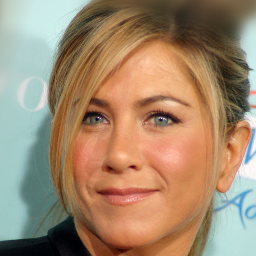

In [ ]:
#@title Align the Image
image_path = "/content/JenniferAnistonFeb09.jpg" #@param {type: "string"}
original_image = Image.open(image_path)
original_image = original_image.convert("RGB")
if experiment_type == "ffhq_encode" and 'shape_predictor_68_face_landmarks.dat' not in os.listdir():
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

def run_alignment(image_path):
  import dlib
  from utils.alignment import align_face
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  aligned_image = align_face(filepath=image_path, predictor=predictor) 
  print("Aligned image has shape: {}".format(aligned_image.size))
  return aligned_image 

if experiment_type == "ffhq_encode":
  input_image = run_alignment(image_path)
else:
  input_image = original_image

input_image.resize(resize_dims)

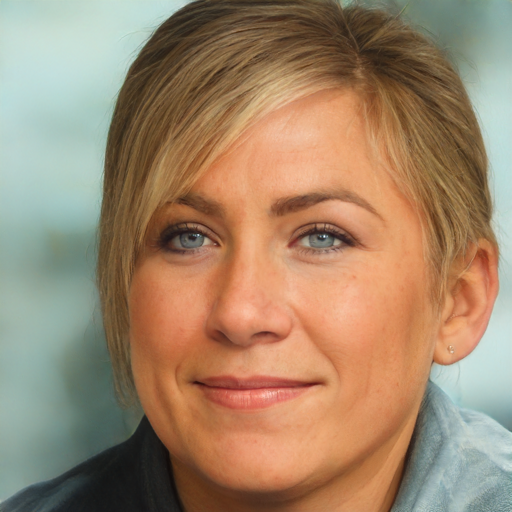

In [ ]:
#@title Invert the Image
img_transforms = EXPERIMENT_ARGS['transform']
transformed_image = img_transforms(input_image)

def display_alongside_source_image(result_image, source_image):
    res = np.concatenate([np.array(source_image.resize(resize_dims)),
                          np.array(result_image.resize(resize_dims))], axis=1)
    return Image.fromarray(res)

def run_on_batch(inputs, net):
    images, latents = net(inputs.to("cuda").float(), randomize_noise=False, return_latents=True)
    if experiment_type == 'cars_encode':
        images = images[:, :, 32:224, :]
    return images, latents

with torch.no_grad():
    images, latents = run_on_batch(transformed_image.unsqueeze(0), net)
    result_image, latent = images[0], latents[0]
torch.save(latents, 'latents.pt')

# Display inversion:
display_alongside_source_image(tensor2im(result_image), input_image)

mode='real image'

if mode == 'real image':
  img_index = 0
  latents=torch.load('/content/encoder4editing/latents.pt')
  w_plus=latents.cpu().detach().numpy()
  dlatents_loaded=M.W2S(w_plus)

  img_indexs=[img_index]
  dlatent_tmp=[tmp[img_indexs] for tmp in dlatents_loaded]
elif mode == 'generated image':
  img_indexs=[img_index]
  dlatent_tmp=[tmp[img_indexs] for tmp in M.dlatents]
M.num_images=len(img_indexs)

M.alpha=[0]
M.manipulate_layers=[0]
codes,out=M.EditOneC(0,dlatent_tmp) 
original=Image.fromarray(out[0,0]).resize((512,512))
M.manipulate_layers=None
original

0.5693
num of channels being manipulated: 30


(-0.5, 1023.5, 1023.5, -0.5)

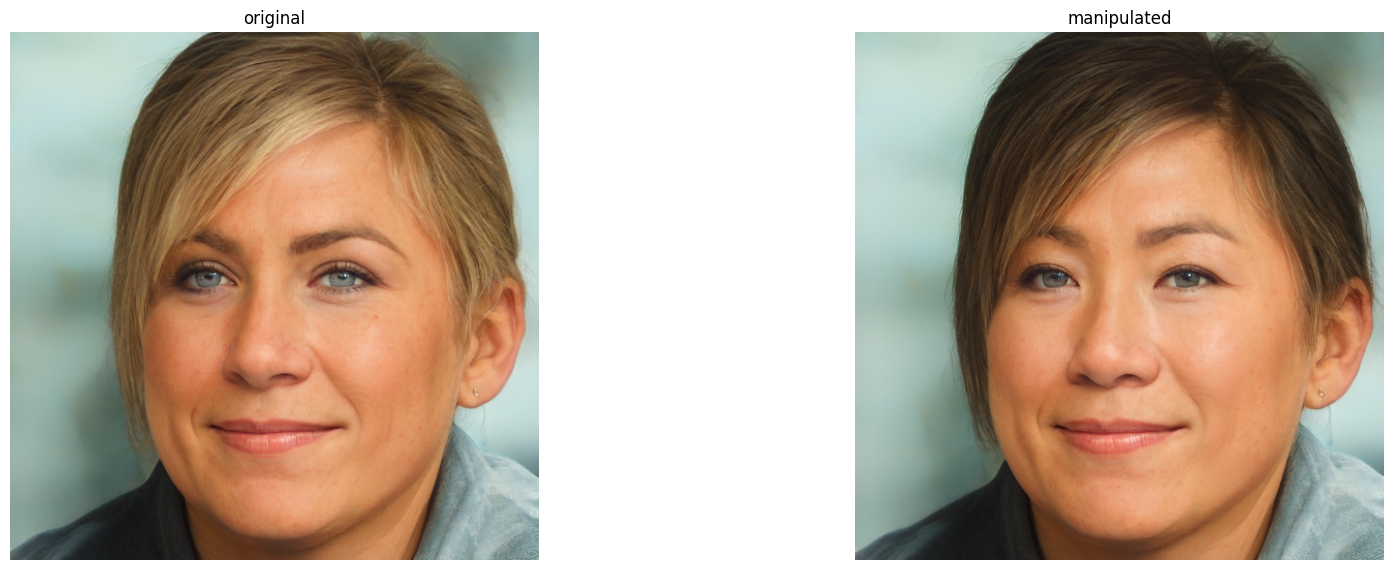

In [ ]:
#@title Modify the Image
neutral='Caucasian woman with hair' #@param {type:"string"}
target='Korean woman with brown hair' #@param {type:"string"}
classnames=[target,neutral]
dt=GetDt(classnames,model)

alpha = 3.5 #@param {type:"slider", min:-10, max:10, step:0.1}
beta = 0.15 #@param {type:"slider", min:0.08, max:0.3, step:0.01}
M.alpha=[alpha]
boundary_tmp2,c=GetBoundary(fs3,dt,M,threshold=beta)
codes=M.MSCode(dlatent_tmp,boundary_tmp2)
out=M.GenerateImg(codes)
generated=Image.fromarray(out[0,0])#.resize((512,512))

plt.figure(figsize=(20,7), dpi= 100)
plt.subplot(1,2,1)
plt.imshow(original)
plt.title('original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(generated)
plt.title('manipulated')
plt.axis('off')